In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LinearRegression

plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

BASE_DIR = Path.cwd().parent
DATA_PATH = BASE_DIR / "data" / "processed" / "master_marketplace_data.parquet"
IMG_DIR = BASE_DIR / "images"
IMG_DIR.mkdir(parents=True, exist_ok=True)

df = pd.read_parquet(DATA_PATH)

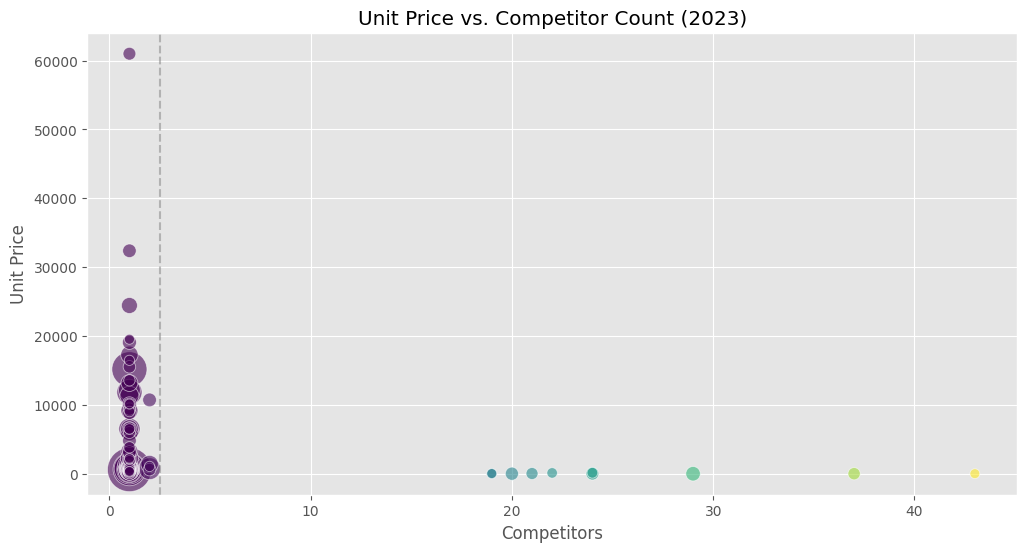

In [2]:
latest_year = df['year'].max()
df_latest = df[df['year'] == latest_year].copy()
subset = df_latest.sort_values('total_spending', ascending=False).head(100)

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=subset, 
    x='manufacturer_count', 
    y='cost_per_claim', 
    size='total_spending', 
    sizes=(50, 1000), 
    alpha=0.6, 
    legend=False,
    hue='manufacturer_count',
    palette='viridis'
)
plt.title(f"Unit Price vs. Competitor Count ({latest_year})")
plt.xlabel("Competitors")
plt.ylabel("Unit Price")
plt.axvline(x=2.5, color='grey', linestyle='--', alpha=0.5)
plt.savefig(IMG_DIR / "market_structure.png")
plt.show()

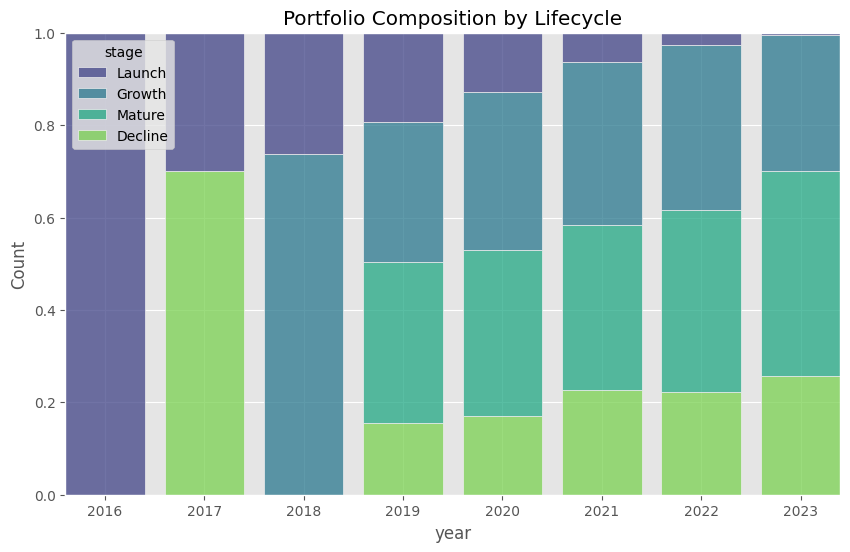

In [3]:
df_life = df.sort_values(['clean_name', 'year']).copy()
df_life['growth'] = df_life.groupby('clean_name')['total_claims'].pct_change()

def get_stage(g):
    if pd.isna(g): return 'Launch'
    if g > 0.15: return 'Growth'
    if -0.05 <= g <= 0.15: return 'Mature'
    return 'Decline'

df_life['stage'] = df_life['growth'].apply(get_stage)
top_products = df_life[df_life['clean_name'].isin(df_latest.sort_values('total_spending', ascending=False).head(500)['clean_name'])]

plt.figure(figsize=(10, 6))
sns.histplot(
    data=top_products, 
    x='year', 
    hue='stage', 
    multiple='fill', 
    discrete=True, 
    palette='viridis',
    shrink=0.8
)
plt.title("Portfolio Composition by Lifecycle")
plt.savefig(IMG_DIR / "lifecycle.png")
plt.show()

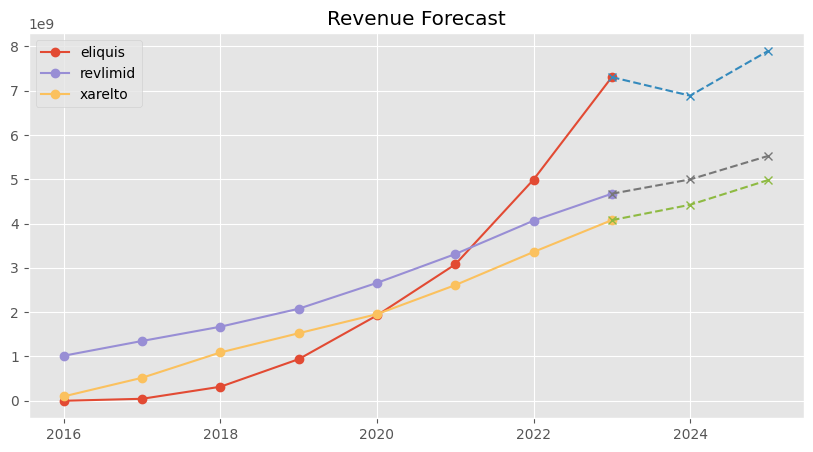

In [4]:
top_3 = df_latest.sort_values('total_spending', ascending=False).head(3)['clean_name'].tolist()

plt.figure(figsize=(10, 5))
for product in top_3:
    data = df[df['clean_name'] == product].sort_values('year')
    X = data[['year']].values
    y = data['total_spending'].values
    
    model = LinearRegression().fit(X, y)
    future = np.array([[latest_year + 1], [latest_year + 2]])
    preds = model.predict(future)
    
    plt.plot(data['year'], y, marker='o', label=product)
    plt.plot([latest_year, latest_year + 1, latest_year + 2], [y[-1], preds[0], preds[1]], linestyle='--', marker='x')

plt.title("Revenue Forecast")
plt.legend()
plt.savefig(IMG_DIR / "forecast.png")
plt.show()

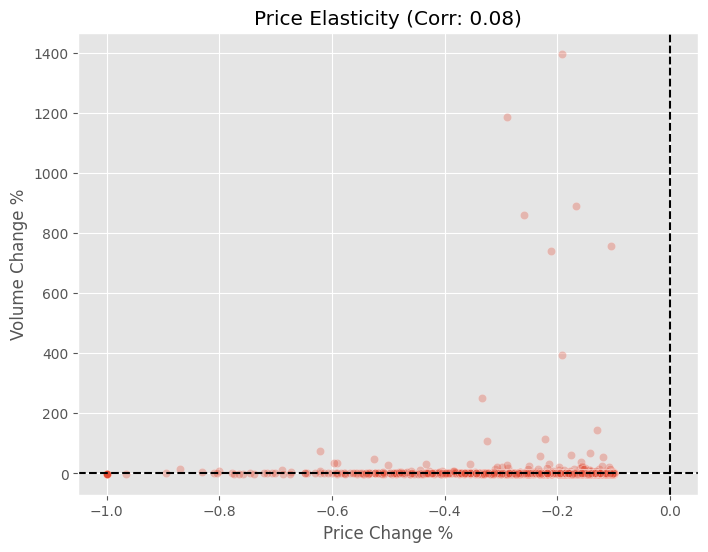

In [5]:
df_elast = df.sort_values(['clean_name', 'year']).copy()
df_elast['price_chg'] = df_elast.groupby('clean_name')['cost_per_claim'].pct_change()
df_elast['vol_chg'] = df_elast.groupby('clean_name')['total_claims'].pct_change()

drops = df_elast[df_elast['price_chg'] < -0.10].copy()
corr = drops['price_chg'].corr(drops['vol_chg'])

plt.figure(figsize=(8, 6))
sns.scatterplot(data=drops, x='price_chg', y='vol_chg', alpha=0.3)
plt.axvline(0, color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
plt.title(f"Price Elasticity (Corr: {corr:.2f})")
plt.xlabel("Price Change %")
plt.ylabel("Volume Change %")
plt.savefig(IMG_DIR / "elasticity.png")
plt.show()